In [1]:
import os
from os import path as osp
import gc
import pickle
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [2]:
train_dir = osp.join(os.getcwd(), 'Imagenet64_train')
batches = os.listdir(train_dir)
batches = [osp.join(train_dir, batch_dir) for batch_dir in batches]
batches.append(osp.join(os.getcwd(), 'val_data'))

In [3]:
def load_batch(batch_dir, img_size=64):
    with open(batch_dir, 'rb') as f:
        d = pickle.load(f)

    x = d['data']
    y = d['labels']
    #means = d['mean']

    x =  x/np.float32(255)
    #means = means/np.float32(255)
    
    y = [i-1 for i in y]
    data_size = x.shape[0]

    img_size2 = img_size**2
    x = np.dstack((x[:, :img_size2], x[:, img_size2:2*img_size2], x[:, 2*img_size2:]))
    x = x.reshape((x.shape[0], img_size, img_size, 3))#.transpose(0, 3, 1, 2)
    X_train = x[0:data_size, :, :, :]
    y_train = y[0:data_size]
    
    # not sure why the images is flipped here
    #X_train_flip = X_train[:, :, :, ::-1]
    #X_train = np.concatenate((X_train, X_train_flip), axis=0)

    return X_train, y_train

def preview_img(img_data, n_imgs=10):
    fig, axis = plt.subplots(1,n_imgs,figsize=(15,15))
    for idx, ax in enumerate(axis):
        # expects array in hwc ordering
        img = img_data[idx]#.transpose(1,2,0)
        ax.imshow(img)
        ax.axis('off')
    #cv2.imshow('', img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

In [4]:
x, y = load_batch(batches[-1])

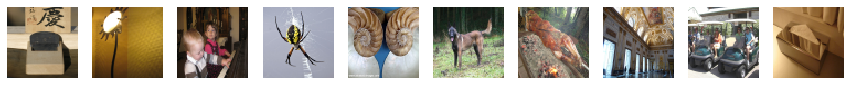

In [5]:
preview_img(x)
del x, y

In [6]:
import asyncio

async def batch_size(batch):
    with open (batch, 'rb') as f:
        d = pickle.load(f)
    return d['data'].shape[0]

async def len_dataset(batches):    
    tasks = [asyncio.create_task(batch_size(batch)) for batch in batches]
    size = 0
    for task in tasks:
        size += await task
        print(size)
        
    return size

In [7]:
size = await len_dataset(batches)
max_path = str(size)
len(max_path)

128116
256232
384348
512464
640580
768703
896819
1024935
1153051
1281167
1331167


7

In [8]:
class Count:
    # counter object needed for generating new
    # image id's
    def __init__(self, start=0, pad=7):
        self.counts = start
        self.pad = '0' + str(pad)
    def update(self):
        self.counts += 1
    def __repr__(self):
        return format(self.counts, self.pad)

In [9]:
# make new directory structure
path = osp.join(os.getcwd(), 'Imagenet64')

if not osp.exists(path):
    os.mkdir(path)
    
imgs_dir = osp.join(path, 'images')
if not osp.exists(imgs_dir):
    os.mkdir(imgs_dir)
    
labels_dir = osp.join(path, 'labels')
if not osp.exists(labels_dir):
    os.mkdir(labels_dir)

In [10]:
%%time

counter = Count(pad=len(max_path))
for batch in batches:
    x, y = load_batch(batch)
    for item in zip(x,y):
        id = str(counter)

        # store image
        os.chdir(imgs_dir)
        matplotlib.image.imsave(id+'.png', item[0])

        # store label
        os.chdir(labels_dir)
        with open(id+'.txt','w') as f:
            print(item[1], file=f)

        counter.update()

CPU times: user 36min 8s, sys: 2min 50s, total: 38min 59s
Wall time: 1h 34min 23s
